In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from textwrap import wrap

from math import *

Для начала зададим некоторый набор переменных: частоту $\Omega=2\pi$, $\Delta \omega=0.1$.

Тогда период $T=\frac{2\pi}{\Omega}=1$. Общее время исследования положим $L=nT$, где переменная $n \in \mathbb{N}$. Положим $n=5$ для первоначальных исследований.

Наиболее болезненным является вопрос сетки: положим на ней отрезок $[0; L]$ с `N_grid` точек, полученный шаг сетки обозначим $h$, $h=\frac{L}{N_{grid}+1}$.

In [3]:
W=2*np.pi
dw=0.1
T=(2*np.pi)/W
n=15
L=n*T

N_grid=6000
t=np.linspace(0,L,N_grid)
h=t[1]-t[0]

Зададим функцию $k_0(t)$ - первое приближение параметров системы. 

$$ k_0(t)=\begin{cases}d, \quad 0 \le t \le 2T \text{ или } t \ge 2T+\tau \\ d+\Delta d, \quad 0 \le t \le 2T+\tau \end{cases} $$ 


Здесь $d$  положим невозмущенным значением; $\Delta d$ - амплитудой шока; $\tau$ - длительностью шока.

Для программного задания ведем дополнительный параметр: количество точек на период $p=\frac{T}{h}$; аналогично $s$ - для длины шока, $sh=\tau$.

In [4]:
p=int(round(T/h))
p

400

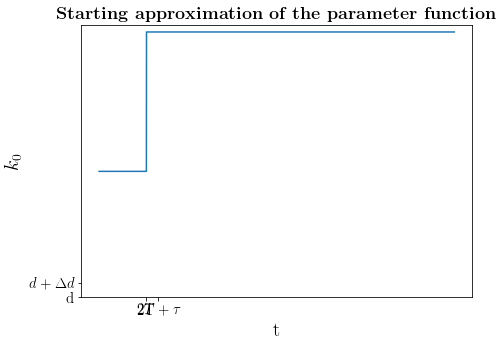

In [7]:
d=2.5
dd=2.5

s=N_grid-2*p

k0=np.array([d]*N_grid)
k0[2*p:2*p+s]=d+dd

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(7, 5))
plt.plot(t, k0)
plt.xlabel(r't', fontsize=20)
plt.ylabel(r'$k_0$', fontsize=20)
plt.xticks([2, 2.5], [r"2T", r"$2T+\tau$"], fontsize=15)
plt.yticks([0.25, 0.5], [r"d", r"$d+\Delta d$"], fontsize=15)
plt.title(r'\textbf{Starting approximation of the parameter function}', fontsize=18)
#plt.savefig('k0_try.eps', format='eps', dpi=1000)
plt.show()

Для более удобного численного метода введем дополнительную функцию, которая есть интерполяция функции $k_0$:

In [8]:
k0_f=interpolate.interp1d(t, k0, bounds_error=False, fill_value="extrapolate")

print(k0_f(t[2]+h/2), k0_f(t[2*p]-h/2), k0_f(t[N_grid-1]+h))

2.5 3.749999999999778 5.0


Поскольку в `python` довольно странным образом написан метод Рунге-Кутты, реализуем его самостоятельно. Пусть дано:

$$
\dot{x}=f(x, t)
$$

В нашем случае:

$$
\dot{\theta}=2\Delta w - k(t)\sin\theta
$$

In [9]:
f=lambda t, x: 2*dw-k0_f(t)*sin(x)
print(f(1, 0))

0.2


Теперь запишем сам метод Рунге-Кутты для данного уравнения (здесь и далее $t_i$ - $i-$ый момент времени, переменная `init` - начальное значение в момент времени $t=0$):

$$\begin{align}
x_0=&init \\
x_{i+1}=&x_{i}+\frac{k_1+2k_2+2k_3+k_4}{6}
\end{align}$$

где

$$
\begin{align}
k_1=& f(t_i, x_i)h \\
k_2=& f(t_i+h/2, x_i+k_1/2)h \\
k_3=& f(t_i+h/2, x_i+k_2/2)h \\
k_4=& f(t_i+h, x_i+k_3)h
\end{align}
$$

Поскольку мы занимаемся восстановлением, положим: $init=\arcsin\left(\frac{2\Delta w}{k_0(0)}\right)$

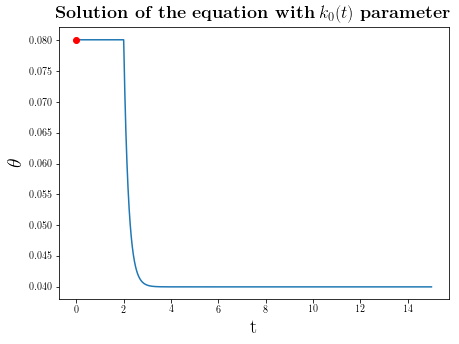

In [11]:
init=np.arcsin(2*dw/k0[0])

theta=[0]*N_grid
for i in range(N_grid):
    if i==0:
        theta[i]=init
    else:
        k1=f(t[i-1], theta[i-1])*h
        k2=f(t[i-1]+h/2, theta[i-1]+k1/2)*h
        k3=f(t[i-1]+h/2, theta[i-1]+k2/2)*h
        k4=f(t[i-1]+h, theta[i-1]+k3)*h
        
        theta[i]=theta[i-1]+(k1+2*k2+2*k3+k4)/6
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(7, 5))
plt.plot(t, theta)
plt.plot(0, init, 'ro')
plt.xlabel(r't', fontsize=20)
plt.ylabel(r'$\theta $', fontsize=20)
plt.title(r'\textbf{Solution of the equation with} $k_0(t)$ \textbf{parameter}', fontsize=18)
plt.show()

Теперь произведем процесс восстановления. Заведем виртуальные маятники:

$$
\begin{cases}
x_0(t)=\sin(\Omega t) \\
y_0(t)=\sin(\Omega t +\theta(t))
\end{cases}
$$

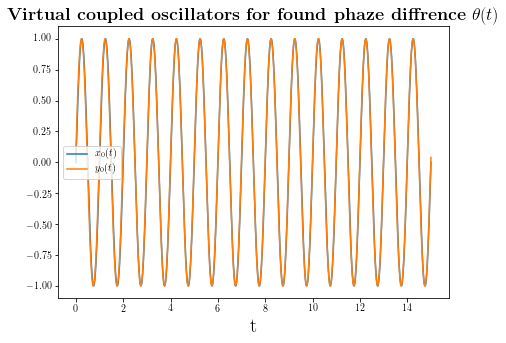

In [13]:
theta=np.array(theta)

x0=np.sin(W*t)
y0=np.sin(W*t+theta)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(7, 5))
plt.plot(t, x0, label='x_0(t)')
plt.plot(t, y0, label='y_0(t)')
plt.legend(['$x_0(t)$', '$y_0(t)$'])
plt.xlabel(r't', fontsize=20)
plt.title(r'\textbf{Virtual coupled oscillators for found phaze diffrence} $\theta (t)$', fontsize=18)
plt.show()

Теперь посчитаем скользящую корреляцию между ними по страшной-страшной формуле:

$$
C_{0}(t)=\frac{\int_{t-T/2}^{t+T/2}\sin(\Omega\tau)\sin(\Omega\tau+\theta(\tau))d\tau}{\sqrt{\int_{t-T/2}^{t+T/2}\sin^{2}(\Omega\tau)d\tau\cdot\int_{t-T/2}^{t+T/2}\sin^{2}(\Omega\tau+\theta(\tau))d\tau}},
$$

Здесь есть небольшой нюанс - у нас нет отрицательных времен и времен, больших чем $L$. Соответственно, наше $C_0(t)$ будет существовать на чуть меньшем отрезке, чем $t$.

Если бы фазовая разница между маятниками была постоянна, что $C_0(t)=\cos \theta$. Положим по идее нашего восстановления, что это почти так, и посчитаем $\varphi_0$:

$$
\varphi_0(t)=\arccos(C_0(t))
$$

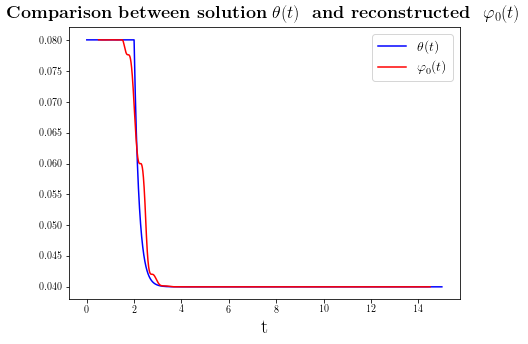

In [15]:
C_0=[0]*N_grid

for i in range(N_grid):
    if (t[i]-T/2>=0) and (t[i]+T/2<=L):
        C_0[i]=np.corrcoef(x0[i-int(p/2):i+int(p/2)], y0[i-int(p/2):i+int(p/2)])[0][1]
    else:
        C_0[i]=nan
        
phi0=np.arccos(C_0)
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(7, 5))
plt.plot(t, theta, 'b')
plt.plot(t, phi0, 'r')
plt.legend([r'$\theta(t)$', r'$\varphi_0(t)$'], fontsize=14)
plt.xlabel(r't', fontsize=20)
plt.title(r'\textbf{Comparison between solution} $\theta (t)$ \textbf{ and reconstructed } $\varphi_0(t)$', fontsize=18)
plt.show()

Теперь воспользуемся предположением о квази-стационарности найденного решения, т.е. 

$$
\varphi'(t) \equiv 0
$$

И восстановим $\hat{k}(t)$:

$$
\hat{k}=\frac{2\Delta w}{\sin \phi_0}
$$

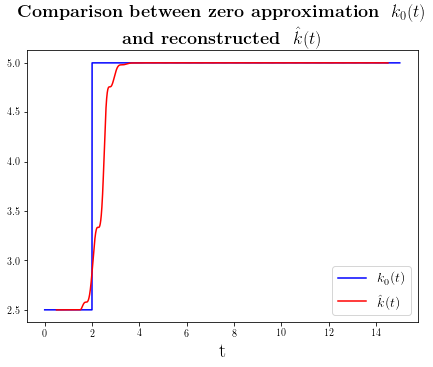

In [16]:
k_hat=np.divide(np.array([2*dw]*N_grid), np.sin(phi0))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(7, 5))
plt.plot(t, k0, 'b')
plt.plot(t, k_hat, 'r')
plt.legend([r'$k_0(t)$', r'$\hat{k}(t)$'], fontsize=14)
plt.xlabel(r't', fontsize=20)
plt.title("\n".join(wrap(r'\textbf{Comparison between zero approximation } $k_0(t)$ \textbf{ and reconstructed } $\hat{k}(t)$', 60)), fontsize=18)
#plt.title(r'\textbf{Comparison between zero approximation } $k_0(t)$ \textbf{ and reconstructed } $\hat{k}(t)$')
#plt.savefig('/home/mryodo/gdrive/sun.activity/pic/2306_khat_neg_9200_50.eps', format='eps')
plt.show()

